In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Distributions
using Interpolations
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout,sigm # param, param0, xavier_uniform
using Knet
using Images
using Plots
using LinearAlgebra
using IterTools: ncycle, takenth
using MLDatasets
using Base.Iterators: flatten
import CUDA # functional
using ImageTransformations
using Statistics
using Memento
using NPZ
# using Interpolations
using Random
using LaTeXStrings
atype=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

const F = Float32
params = Knet.params

cd("..")

include("PlotUtility.jl")
include("ImageUtility.jl")
include("TrainUtility.jl")
include("LayerUtility.jl")
include("LossUtility.jl")

using .PlotUtility
using .ImageUtility
using .TrainUtility
using .LayerUtility
using .LossUtility

########################### CHANGE THIS LINE FOR DATASET PARAMETER ##############################
dataset_name = "mnist"
exp_number = 1
########################### CHANGE THIS LINE FOR RESULT FOLDER NAME #############################
notebook_name = "Ablation_Study_Initial_Point" * "_" * dataset_name * string(exp_number)

use_saved_data = true
nc = nothing

if dataset_name == "mnist"
    nc = 1
    if use_saved_data
        xtrn = npzread("Data/MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))

    else

        xtrn,_ = MNIST.traindata()
        xtst,_ = MNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)
        
    end
    
elseif dataset_name == "fashion"
    nc = 1
    if use_saved_data

        xtrn = npzread("Data/Fashion_MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/Fashion_MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))
        
    else
        
        xtrn,_ = FashionMNIST.traindata()
        xtst,_ = FashionMNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)

    end
    
elseif dataset_name == "cifar"
    nc = 3
    xtrn,_= CIFAR10.traindata()
    xtst,_ = CIFAR10.testdata()
    xtrn = Array{Float64, 4}(xtrn)
    xtst = Array{Float64, 4}(xtst)

elseif dataset_name == "coil"
    coil_path = "Data/coil20"
    coil = load_coil_dataset(coil_path);
    nc = 1
    dataset_size = size(coil,3)
    trn_perc = 0.8
    trn_size = Int(dataset_size * trn_perc)
    random_permutation = randperm(dataset_size)
    trn_idx = random_permutation[1:trn_size]
    tst_idx = random_permutation[trn_size + 1:end]
    xtrn = coil[:,:,trn_idx]
    xtrn = resize_gray_image_tensor(xtrn, 1/4)
    xtst = coil[:,:,tst_idx];
    xtst = resize_gray_image_tensor(xtst, 1/4)

end

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32, 32, nc,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (32, 32, nc,:), xtype = atype);

function weights(nc, nz,  ngf) 
        
    # Decoding Weights
    theta = [] # z -> x
    
    w, b = deconv_weight_init(4, 4, nz, ngf * 4;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    push!(theta, (bnparams(ngf * 4))) # Batch Normalization
    
    w, b = deconv_weight_init(4, 4, ngf * 4, ngf * 2;bias= true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    push!(theta, (bnparams(ngf * 2)))
    
    w, b = deconv_weight_init(4, 4, ngf * 2, ngf;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    push!(theta, (bnparams(ngf)))
    
    w,b = deconv_weight_init(4,4,ngf, nc;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)

    theta = map(a->convert(atype,a), theta)
    
    return Param.(theta)
end

moments1 = bnmoments()
moments2 = bnmoments()
moments3 = bnmoments()

function decode(theta, z; batch_size = 64, training = true)
    
    z = deconv4(theta[1], z, mode = 1) .+ theta[2]
    z = mybatchnorm(z, moments1, theta[3]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[4], z, mode = 1, stride = 2, padding = 1) .+ theta[5]
    z = mybatchnorm(z, moments2, theta[6]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[7], z, mode = 1, stride = 2, padding = 1) .+ theta[8]
    z = mybatchnorm(z, moments3, theta[9]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[10], z, mode = 1, stride = 2, padding = 1) .+ theta[11]
    x_hat = Knet.sigm.(z)
    return x_hat
    
end

# (Reconstruction Error := Mean Squared Error)
inner_loss(x, z) = mean(sum((decode(theta, z; batch_size = size(x,4)) - x).^2, dims = 3))

function loss_train(theta, x)
    x_hat =  decode_train(theta, x; batch_size = size(x,4))
    L = mean(sum((x_hat - x).^2, dims = 3))
end

function loss_train(theta, d::Data)
    total_loss = 0
    n_instance = 0
    for x in d
        total_loss += loss_train(theta, x) * size(x,4)
        n_instance += size(x,4)
    end
    
    total_loss /= n_instance
end


loss_train (generic function with 2 methods)

# Train With Zero Initialization

In [2]:
function decode_train(theta, x; batch_size = 64)
    origin = Param(atype(zeros(1, 1, nz, batch_size)))
    derivative_origin = @diff inner_loss(x,origin)
    dz = grad(derivative_origin, origin)
    z = -dz
    x_hat = decode(theta, z; batch_size = batch_size, training = true)
    return x_hat
end

nz = 256
ngf = 16
# nc = 1

# first batch of the test dataset
x_test_first = first(dtst);

# define model weights
theta = weights(nc, nz,  ngf);

# Define Learning Rate and Number of Epochs
lr = 2*1e-4
n_epochs = 50

# optim = Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999)

# Specify the optimizer for each param
for p in params(theta)
    p.opt =  Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999)
end
# Initialize Empty Lists for both training and test losses
trn_loss_list0 = Float64[]
tst_loss_list0 = Float64[]

# RECORD INITIAL LOSS VALUES
epoch_loss_trn_ = loss_train(theta, dtrn)
epoch_loss_tst_ = loss_train(theta, dtst)
push!(trn_loss_list0, epoch_loss_trn_)
push!(tst_loss_list0, epoch_loss_tst_)

# Training Loop
for epoch in progress(1:n_epochs)
    for (i,x) in enumerate(dtrn)
        
        derivative_model = @diff loss_train(theta, x)
        
        for p in theta
            dp = grad(derivative_model, p)
            update!(value(p), dp, p.opt)
        end

    end
    
    epoch_loss_trn = loss_train(theta, dtrn)
    epoch_loss_tst = loss_train(theta, dtst)
    print(epoch_loss_trn)
    push!(trn_loss_list0, epoch_loss_trn)
    push!(tst_loss_list0, epoch_loss_tst)
end

┣▊                   ┫ [4.00%, 2/50, 00:27/11:26, 27.43s/i] 

0.0039367443

┣█▏                  ┫ [6.00%, 3/50, 00:48/13:14, 20.23s/i] 

0.0016238908

┣█▌                  ┫ [8.00%, 4/50, 01:08/14:11, 20.39s/i] 

0.0012192451

┣██                  ┫ [10.00%, 5/50, 01:28/14:41, 20.05s/i] 

0.001003728

┣██▍                 ┫ [12.00%, 6/50, 01:48/15:02, 20.16s/i] 

0.0009372592

┣██▊                 ┫ [14.00%, 7/50, 02:08/15:18, 20.22s/i] 

0.00085472735

┣███▏                ┫ [16.00%, 8/50, 02:29/15:28, 20.06s/i] 

0.0008148229

┣███▌                ┫ [18.00%, 9/50, 02:49/15:37, 20.18s/i] 

0.0007549772

┣████                ┫ [20.00%, 10/50, 03:09/15:44, 20.11s/i] 

0.0007280628

┣████▍               ┫ [22.00%, 11/50, 03:29/15:50, 20.26s/i] 

0.0006960702

┣████▊               ┫ [24.00%, 12/50, 03:49/15:55, 20.20s/i] 

0.0006642701

┣█████▏              ┫ [26.00%, 13/50, 04:09/15:59, 20.15s/i] 

0.0006620304

┣█████▌              ┫ [28.00%, 14/50, 04:30/16:03, 20.18s/i] 

0.0006274129

┣██████              ┫ [30.00%, 15/50, 04:50/16:06, 20.23s/i] 

0.00061334163

┣██████▍             ┫ [32.00%, 16/50, 05:10/16:09, 20.21s/i] 

0.00058597303

┣██████▊             ┫ [34.00%, 17/50, 05:30/16:11, 20.22s/i] 

0.0005708922

┣███████▏            ┫ [36.00%, 18/50, 05:51/16:14, 20.46s/i] 

0.0005623303

┣███████▌            ┫ [38.00%, 19/50, 06:11/16:16, 20.25s/i] 

0.0005373531

┣████████            ┫ [40.00%, 20/50, 06:31/16:18, 20.21s/i] 

0.0005350604

┣████████▍           ┫ [42.00%, 21/50, 06:52/16:20, 20.44s/i] 

0.00053436257

┣████████▊           ┫ [44.00%, 22/50, 07:12/16:22, 20.30s/i] 

0.00051059783

┣█████████▏          ┫ [46.00%, 23/50, 07:32/16:23, 20.28s/i] 

0.0005034309

┣█████████▌          ┫ [48.00%, 24/50, 07:53/16:25, 20.41s/i] 

0.0004901352

┣██████████          ┫ [50.00%, 25/50, 08:13/16:26, 20.52s/i] 

0.0004826197

┣██████████▍         ┫ [52.00%, 26/50, 08:33/16:27, 20.28s/i] 

0.00047932856

┣██████████▊         ┫ [54.00%, 27/50, 08:54/16:29, 20.42s/i] 

0.0004739412

┣███████████▏        ┫ [56.00%, 28/50, 09:14/16:30, 20.51s/i] 

0.0004642324

┣███████████▌        ┫ [58.00%, 29/50, 09:35/16:31, 20.46s/i] 

0.00045158705

┣████████████        ┫ [60.00%, 30/50, 09:55/16:32, 20.30s/i] 

0.00044875836

┣████████████▍       ┫ [62.00%, 31/50, 10:16/16:33, 20.47s/i] 

0.00044278416

┣████████████▊       ┫ [64.00%, 32/50, 10:36/16:34, 20.48s/i] 

0.00044137903

┣█████████████▏      ┫ [66.00%, 33/50, 10:57/16:35, 20.49s/i] 

0.00042856025

┣█████████████▌      ┫ [68.00%, 34/50, 11:17/16:36, 20.39s/i] 

0.00042768216

┣██████████████      ┫ [70.00%, 35/50, 11:38/16:37, 20.68s/i] 

0.00041971853

┣██████████████▍     ┫ [72.00%, 36/50, 11:58/16:37, 20.48s/i] 

0.00041399073

┣██████████████▊     ┫ [74.00%, 37/50, 12:19/16:38, 20.46s/i] 

0.00040901173

┣███████████████▏    ┫ [76.00%, 38/50, 12:39/16:39, 20.48s/i] 

0.00040692987

┣███████████████▌    ┫ [78.00%, 39/50, 13:01/16:41, 21.51s/i] 

0.0004124225

┣████████████████    ┫ [80.00%, 40/50, 13:21/16:41, 20.47s/i] 

0.0003975657

┣████████████████▍   ┫ [82.00%, 41/50, 13:42/16:42, 20.60s/i] 

0.00040104002

┣████████████████▊   ┫ [84.00%, 42/50, 14:02/16:43, 20.54s/i] 

0.00039506145

┣█████████████████▏  ┫ [86.00%, 43/50, 14:23/16:43, 20.54s/i] 

0.0003883233

┣█████████████████▌  ┫ [88.00%, 44/50, 14:43/16:44, 20.50s/i] 

0.0003834946

┣██████████████████  ┫ [90.00%, 45/50, 15:05/16:46, 22.14s/i] 

0.00038728354

┣██████████████████▍ ┫ [92.00%, 46/50, 15:28/16:49, 22.80s/i] 

0.00037792805

┣██████████████████▊ ┫ [94.00%, 47/50, 15:51/16:52, 22.90s/i] 

0.00038001104

┣███████████████████▏┫ [96.00%, 48/50, 16:12/16:53, 21.33s/i] 

0.00037309958

┣███████████████████▌┫ [98.00%, 49/50, 16:34/16:54, 21.83s/i] 

0.0003700715

┣████████████████████┫ [100.00%, 50/50, 16:56/16:56, 22.28s/i] 

0.00036996775

┣████████████████████┫ [100.00%, 50/50, 17:19/17:19, 20.79s/i] 


0.00036094

# Train With Zero Mean 0.01 Std Initialization

In [3]:
function decode_train(theta, x; batch_size = 64)
    origin = Param(atype(0.01 * randn(1, 1, nz, batch_size)))
    derivative_origin = @diff inner_loss(x,origin)
    dz = grad(derivative_origin, origin)
    z = origin-dz
    x_hat = decode(theta, z; batch_size = batch_size, training = true)
    return x_hat
end

nz = 256
ngf = 16
# nc = 1

# first batch of the test dataset
x_test_first = first(dtst);

# define model weights
theta = weights(nc, nz,  ngf);

# Define Learning Rate and Number of Epochs
lr = 2*1e-4
# n_epochs = 3

# optim = Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999)

# Specify the optimizer for each param
for p in params(theta)
    p.opt =  Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999)
end
# Initialize Empty Lists for both training and test losses
trn_loss_list1 = Float64[]
tst_loss_list1 = Float64[]

# RECORD INITIAL LOSS VALUES
epoch_loss_trn_ = loss_train(theta, dtrn)
epoch_loss_tst_ = loss_train(theta, dtst)
push!(trn_loss_list1, epoch_loss_trn_)
push!(tst_loss_list1, epoch_loss_tst_)

# Training Loop
for epoch in progress(1:n_epochs)
    for (i,x) in enumerate(dtrn)
        
        derivative_model = @diff loss_train(theta, x)
        
        for p in theta
            dp = grad(derivative_model, p)
            update!(value(p), dp, p.opt)
        end

    end
    
    epoch_loss_trn = loss_train(theta, dtrn)
    epoch_loss_tst = loss_train(theta, dtst)
    print(epoch_loss_trn)
    push!(trn_loss_list1, epoch_loss_trn)
    push!(tst_loss_list1, epoch_loss_tst)
end

┣▊                   ┫ [4.00%, 2/50, 00:23/09:45, 23.41s/i] 

0.037669875

┣█▏                  ┫ [6.00%, 3/50, 00:45/12:32, 21.69s/i] 

0.03441152

┣█▌                  ┫ [8.00%, 4/50, 01:07/14:04, 22.39s/i] 

0.033072572

┣██                  ┫ [10.00%, 5/50, 01:31/15:06, 23.06s/i] 

0.032292247

┣██▍                 ┫ [12.00%, 6/50, 01:54/15:48, 23.21s/i] 

0.03166837

┣██▊                 ┫ [14.00%, 7/50, 02:17/16:20, 23.42s/i] 

0.031210003

┣███▏                ┫ [16.00%, 8/50, 02:39/16:31, 21.33s/i] 

0.030940501

┣███▌                ┫ [18.00%, 9/50, 03:01/16:47, 22.73s/i] 

0.030536951

┣████                ┫ [20.00%, 10/50, 03:25/17:03, 23.42s/i] 

0.030286541

┣████▍               ┫ [22.00%, 11/50, 03:48/17:16, 23.37s/i] 

0.030007288

┣████▊               ┫ [24.00%, 12/50, 04:11/17:26, 22.99s/i] 

0.029784052

┣█████▏              ┫ [26.00%, 13/50, 04:33/17:29, 21.68s/i] 

0.02953666

┣█████▌              ┫ [28.00%, 14/50, 04:55/17:35, 22.61s/i] 

0.029224398

┣██████              ┫ [30.00%, 15/50, 05:19/17:42, 23.44s/i] 

0.02905918

┣██████▍             ┫ [32.00%, 16/50, 05:42/17:49, 23.41s/i] 

0.028860915

┣██████▊             ┫ [34.00%, 17/50, 06:05/17:53, 22.58s/i] 

0.028625708

┣███████▏            ┫ [36.00%, 18/50, 06:27/17:55, 22.33s/i] 

0.028396554

┣███████▌            ┫ [38.00%, 19/50, 06:50/17:59, 22.85s/i] 

0.028215768

┣████████            ┫ [40.00%, 20/50, 07:14/18:04, 23.65s/i] 

0.02798982

┣████████▍           ┫ [42.00%, 21/50, 07:37/18:08, 23.45s/i] 

0.027828604

┣████████▊           ┫ [44.00%, 22/50, 07:59/18:08, 21.82s/i] 

0.027633036

┣█████████▏          ┫ [46.00%, 23/50, 08:21/18:10, 22.50s/i] 

0.027451212

┣█████████▌          ┫ [48.00%, 24/50, 08:45/18:13, 23.39s/i] 

0.027276035

┣██████████          ┫ [50.00%, 25/50, 09:08/18:17, 23.55s/i] 

0.02714995

┣██████████▍         ┫ [52.00%, 26/50, 09:32/18:20, 23.59s/i] 

0.027035786

┣██████████▊         ┫ [54.00%, 27/50, 09:53/18:19, 21.58s/i] 

0.026866699

┣███████████▏        ┫ [56.00%, 28/50, 10:16/18:20, 22.73s/i] 

0.026697094

┣███████████▌        ┫ [58.00%, 29/50, 10:40/18:23, 23.85s/i] 

0.0265974

┣████████████        ┫ [60.00%, 30/50, 11:04/18:26, 23.64s/i] 

0.026466053

┣████████████▍       ┫ [62.00%, 31/50, 11:27/18:27, 22.97s/i] 

0.026347317

┣████████████▊       ┫ [64.00%, 32/50, 11:49/18:28, 22.25s/i] 

0.026198208

┣█████████████▏      ┫ [66.00%, 33/50, 12:12/18:29, 23.11s/i] 

0.026131386

┣█████████████▌      ┫ [68.00%, 34/50, 12:36/18:31, 23.77s/i] 

0.025957687

┣██████████████      ┫ [70.00%, 35/50, 13:00/18:34, 23.81s/i] 

0.02592235

┣██████████████▍     ┫ [72.00%, 36/50, 13:22/18:34, 22.26s/i] 

0.025814665

┣██████████████▊     ┫ [74.00%, 37/50, 13:44/18:34, 22.69s/i] 

0.02572514

┣███████████████▏    ┫ [76.00%, 38/50, 14:08/18:36, 23.76s/i] 

0.025617411

┣███████████████▌    ┫ [78.00%, 39/50, 14:32/18:38, 23.85s/i] 

0.025561312

┣████████████████    ┫ [80.00%, 40/50, 14:56/18:40, 23.63s/i] 

0.025476845

┣████████████████▍   ┫ [82.00%, 41/50, 15:18/18:39, 21.89s/i] 

0.025356583

┣████████████████▊   ┫ [84.00%, 42/50, 15:41/18:40, 23.30s/i] 

0.025332816

┣█████████████████▏  ┫ [86.00%, 43/50, 16:05/18:42, 23.78s/i] 

0.025242263

┣█████████████████▌  ┫ [88.00%, 44/50, 16:29/18:43, 23.99s/i] 

0.02518321

┣██████████████████  ┫ [90.00%, 45/50, 16:52/18:44, 22.96s/i] 

0.025094341

┣██████████████████▍ ┫ [92.00%, 46/50, 17:14/18:44, 22.58s/i] 

0.02501057

┣██████████████████▊ ┫ [94.00%, 47/50, 17:37/18:45, 22.96s/i] 

0.024940189

┣███████████████████▏┫ [96.00%, 48/50, 18:01/18:46, 24.00s/i] 

0.024895895

┣███████████████████▌┫ [98.00%, 49/50, 18:25/18:48, 23.97s/i] 

0.02482531

┣████████████████████┫ [100.00%, 50/50, 18:48/18:48, 22.56s/i] 

0.02476292

┣████████████████████┫ [100.00%, 50/50, 19:11/19:11, 23.01s/i] 


0.024726095

# Train With Zero Mean 0.1 Std Initialization

In [4]:
function decode_train(theta, x; batch_size = 64)
    origin = Param(atype(0.1 * randn(1, 1, nz, batch_size)))
    derivative_origin = @diff inner_loss(x,origin)
    dz = grad(derivative_origin, origin)
    z = origin-dz
    x_hat = decode(theta, z; batch_size = batch_size, training = true)
    return x_hat
end

nz = 256
ngf = 16
# nc = 1

# first batch of the test dataset
x_test_first = first(dtst);

# define model weights
theta = weights(nc, nz,  ngf);

# Define Learning Rate and Number of Epochs
lr = 2*1e-4
# n_epochs = 3

# optim = Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999)

# Specify the optimizer for each param
for p in params(theta)
    p.opt =  Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999)
end
# Initialize Empty Lists for both training and test losses
trn_loss_list2 = Float64[]
tst_loss_list2 = Float64[]

# RECORD INITIAL LOSS VALUES
epoch_loss_trn_ = loss_train(theta, dtrn)
epoch_loss_tst_ = loss_train(theta, dtst)
push!(trn_loss_list2, epoch_loss_trn_)
push!(tst_loss_list2, epoch_loss_tst_)

# Training Loop
for epoch in progress(1:n_epochs)
    for (i,x) in enumerate(dtrn)
        
        derivative_model = @diff loss_train(theta, x)
        
        for p in theta
            dp = grad(derivative_model, p)
            update!(value(p), dp, p.opt)
        end

    end
    
    epoch_loss_trn = loss_train(theta, dtrn)
    epoch_loss_tst = loss_train(theta, dtst)
    print(epoch_loss_trn)
    push!(trn_loss_list2, epoch_loss_trn)
    push!(tst_loss_list2, epoch_loss_tst)
end

┣▊                   ┫ [4.00%, 2/50, 00:24/10:03, 24.12s/i] 

0.065369286

┣█▏                  ┫ [6.00%, 3/50, 00:48/13:23, 24.04s/i] 

0.058097083

┣█▌                  ┫ [8.00%, 4/50, 01:11/14:45, 22.64s/i] 

0.057580054

┣██                  ┫ [10.00%, 5/50, 01:34/15:37, 22.93s/i] 

0.057379622

┣██▍                 ┫ [12.00%, 6/50, 01:57/16:18, 23.68s/i] 

0.057190705

┣██▊                 ┫ [14.00%, 7/50, 02:22/16:51, 24.14s/i] 

0.057163794

┣███▏                ┫ [16.00%, 8/50, 02:46/17:15, 24.07s/i] 

0.057027414

┣███▌                ┫ [18.00%, 9/50, 03:08/17:22, 21.99s/i] 

0.057003316

┣████                ┫ [20.00%, 10/50, 03:31/17:34, 23.26s/i] 

0.056936275

┣████▍               ┫ [22.00%, 11/50, 03:55/17:49, 24.21s/i] 

0.056880977

┣████▊               ┫ [24.00%, 12/50, 04:19/18:00, 24.11s/i] 

0.056839067

┣█████▏              ┫ [26.00%, 13/50, 04:43/18:07, 23.39s/i] 

0.05682926

┣█████▌              ┫ [28.00%, 14/50, 05:05/18:10, 22.75s/i] 

0.056799125

┣██████              ┫ [30.00%, 15/50, 05:29/18:17, 23.70s/i] 

0.05682285

┣██████▍             ┫ [32.00%, 16/50, 05:53/18:24, 24.14s/i] 

0.056764565

┣██████▊             ┫ [34.00%, 17/50, 06:17/18:30, 24.10s/i] 

0.056758836

┣███████▏            ┫ [36.00%, 18/50, 06:39/18:29, 22.12s/i] 

0.056750916

┣███████▌            ┫ [38.00%, 19/50, 07:03/18:33, 23.51s/i] 

0.05670594

┣████████            ┫ [40.00%, 20/50, 07:27/18:38, 24.26s/i] 

0.056704536

┣████████▍           ┫ [42.00%, 21/50, 07:51/18:42, 24.18s/i] 

0.056685265

┣████████▊           ┫ [44.00%, 22/50, 08:15/18:45, 23.62s/i] 

0.05670127

┣█████████▏          ┫ [46.00%, 23/50, 08:38/18:45, 22.57s/i] 

0.056672804

┣█████████▌          ┫ [48.00%, 24/50, 09:01/18:47, 23.58s/i] 

0.056686927

┣██████████          ┫ [50.00%, 25/50, 09:25/18:51, 24.30s/i] 

0.056659278

┣██████████▍         ┫ [52.00%, 26/50, 09:49/18:53, 24.00s/i] 

0.05670658

┣██████████▊         ┫ [54.00%, 27/50, 10:13/18:54, 23.11s/i] 

0.056688685

┣███████████▏        ┫ [56.00%, 28/50, 10:35/18:53, 22.21s/i] 

0.056650795

┣███████████▌        ┫ [58.00%, 29/50, 10:57/18:54, 22.73s/i] 

0.056644488

┣████████████        ┫ [60.00%, 30/50, 11:21/18:55, 23.53s/i] 

0.056642424

┣████████████▍       ┫ [62.00%, 31/50, 11:45/18:57, 24.17s/i] 

0.0566356

┣████████████▊       ┫ [64.00%, 32/50, 12:09/18:59, 23.69s/i] 

0.056648396

┣█████████████▏      ┫ [66.00%, 33/50, 12:32/19:00, 23.59s/i] 

0.056626216

┣█████████████▌      ┫ [68.00%, 34/50, 12:54/18:59, 22.01s/i] 

0.056600764

┣██████████████      ┫ [70.00%, 35/50, 13:18/19:00, 23.30s/i] 

0.056599118

┣██████████████▍     ┫ [72.00%, 36/50, 13:42/19:02, 24.41s/i] 

0.056621492

┣██████████████▊     ┫ [74.00%, 37/50, 14:06/19:04, 24.32s/i] 

0.05659846

┣███████████████▏    ┫ [76.00%, 38/50, 14:30/19:05, 23.73s/i] 

0.05658742

┣███████████████▌    ┫ [78.00%, 39/50, 14:53/19:05, 22.78s/i] 

0.05659712

┣████████████████    ┫ [80.00%, 40/50, 15:16/19:06, 23.46s/i] 

0.056591578

┣████████████████▍   ┫ [82.00%, 41/50, 15:41/19:07, 24.28s/i] 

0.05658241

┣████████████████▊   ┫ [84.00%, 42/50, 16:05/19:09, 24.44s/i] 

0.056577135

┣█████████████████▏  ┫ [86.00%, 43/50, 16:28/19:09, 23.06s/i] 

0.05658868

┣█████████████████▌  ┫ [88.00%, 44/50, 16:51/19:09, 23.16s/i] 

0.056583196

┣██████████████████  ┫ [90.00%, 45/50, 17:16/19:11, 24.40s/i] 

0.056572016

┣██████████████████▍ ┫ [92.00%, 46/50, 17:40/19:12, 24.35s/i] 

0.056610845

┣██████████████████▊ ┫ [94.00%, 47/50, 18:04/19:13, 24.07s/i] 

0.056615718

┣███████████████████▏┫ [96.00%, 48/50, 18:27/19:13, 22.52s/i] 

0.056572635

┣███████████████████▌┫ [98.00%, 49/50, 18:51/19:14, 23.80s/i] 

0.056568183

┣████████████████████┫ [100.00%, 50/50, 19:15/19:15, 24.38s/i] 

0.056549627

┣████████████████████┫ [100.00%, 50/50, 19:39/19:39, 23.59s/i] 


0.05656834

# Train With Zero Mean 1 Std Initialization

In [5]:
function decode_train(theta, x; batch_size = 64)
    origin = Param(atype(randn(1, 1, nz, batch_size)))
    derivative_origin = @diff inner_loss(x,origin)
    dz = grad(derivative_origin, origin)
    z = origin-dz
    x_hat = decode(theta, z; batch_size = batch_size, training = true)
    return x_hat
end

nz = 256
ngf = 16
# nc = 1

# first batch of the test dataset
x_test_first = first(dtst);

# define model weights
theta = weights(nc, nz,  ngf);

# Define Learning Rate and Number of Epochs
lr = 2*1e-4
# n_epochs = 3

# optim = Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999)

# Specify the optimizer for each param
for p in params(theta)
    p.opt =  Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999)
end
# Initialize Empty Lists for both training and test losses
trn_loss_list3 = Float64[]
tst_loss_list3 = Float64[]

# RECORD INITIAL LOSS VALUES
epoch_loss_trn_ = loss_train(theta, dtrn)
epoch_loss_tst_ = loss_train(theta, dtst)
push!(trn_loss_list3, epoch_loss_trn_)
push!(tst_loss_list3, epoch_loss_tst_)

# Training Loop
for epoch in progress(1:n_epochs)
    for (i,x) in enumerate(dtrn)
        
        derivative_model = @diff loss_train(theta, x)
        
        for p in theta
            dp = grad(derivative_model, p)
            update!(value(p), dp, p.opt)
        end

    end
    
    epoch_loss_trn = loss_train(theta, dtrn)
    epoch_loss_tst = loss_train(theta, dtst)
    print(epoch_loss_trn)
    push!(trn_loss_list3, epoch_loss_trn)
    push!(tst_loss_list3, epoch_loss_tst)
end

┣▊                   ┫ [4.00%, 2/50, 00:22/09:12, 22.07s/i] 

0.06095229

┣█▏                  ┫ [6.00%, 3/50, 00:45/12:24, 22.57s/i] 

0.057917424

┣█▌                  ┫ [8.00%, 4/50, 01:08/14:04, 22.86s/i] 

0.05753658

┣██                  ┫ [10.00%, 5/50, 01:29/14:50, 21.52s/i] 

0.057358738

┣██▍                 ┫ [12.00%, 6/50, 01:51/15:27, 22.21s/i] 

0.057173707

┣██▊                 ┫ [14.00%, 7/50, 02:16/16:09, 24.36s/i] 

0.057061303

┣███▏                ┫ [16.00%, 8/50, 02:40/16:40, 24.41s/i] 

0.056997903

┣███▌                ┫ [18.00%, 9/50, 03:03/16:59, 23.39s/i] 

0.05697554

┣████                ┫ [20.00%, 10/50, 03:26/17:12, 23.03s/i] 

0.056888994

┣████▍               ┫ [22.00%, 11/50, 03:50/17:26, 23.69s/i] 

0.05687217

┣████▊               ┫ [24.00%, 12/50, 04:14/17:40, 24.28s/i] 

0.056847643

┣█████▏              ┫ [26.00%, 13/50, 04:39/17:52, 24.41s/i] 

0.056791473

┣█████▌              ┫ [28.00%, 14/50, 05:01/17:55, 22.07s/i] 

0.056856826

┣██████              ┫ [30.00%, 15/50, 05:24/18:01, 23.47s/i] 

0.05675668

┣██████▍             ┫ [32.00%, 16/50, 05:49/18:10, 24.44s/i] 

0.056741506

┣██████▊             ┫ [34.00%, 17/50, 06:13/18:17, 24.31s/i] 

0.05675069

┣███████▏            ┫ [36.00%, 18/50, 06:36/18:21, 23.29s/i] 

0.056719664

┣███████▌            ┫ [38.00%, 19/50, 06:59/18:24, 22.99s/i] 

0.056747023

┣████████            ┫ [40.00%, 20/50, 07:23/18:27, 23.44s/i] 

0.056730285

┣████████▍           ┫ [42.00%, 21/50, 07:47/18:33, 24.48s/i] 

0.05677456

┣████████▊           ┫ [44.00%, 22/50, 08:12/18:38, 24.48s/i] 

0.05667401

┣█████████▏          ┫ [46.00%, 23/50, 08:34/18:38, 22.30s/i] 

0.05665449

┣█████████▌          ┫ [48.00%, 24/50, 08:58/18:40, 23.63s/i] 

0.05665504

┣██████████          ┫ [50.00%, 25/50, 09:22/18:44, 24.36s/i] 

0.05665657

┣██████████▍         ┫ [52.00%, 26/50, 09:47/18:48, 24.47s/i] 

0.056667197

┣██████████▊         ┫ [54.00%, 27/50, 10:10/18:50, 23.52s/i] 

0.056627948

┣███████████▏        ┫ [56.00%, 28/50, 10:33/18:50, 22.96s/i] 

0.05666925

┣███████████▌        ┫ [58.00%, 29/50, 10:56/18:51, 23.15s/i] 

0.056635536

┣████████████        ┫ [60.00%, 30/50, 11:21/18:54, 24.52s/i] 

0.05663104

┣████████████▍       ┫ [62.00%, 31/50, 11:45/18:58, 24.61s/i] 

0.05661729

┣████████████▊       ┫ [64.00%, 32/50, 12:08/18:58, 22.78s/i] 

0.056625888

┣█████████████▏      ┫ [66.00%, 33/50, 12:32/18:59, 23.47s/i] 

0.056609727

┣█████████████▌      ┫ [68.00%, 34/50, 12:56/19:01, 24.59s/i] 

0.05661766

┣██████████████      ┫ [70.00%, 35/50, 13:21/19:04, 24.68s/i] 

0.056589656

┣██████████████▍     ┫ [72.00%, 36/50, 13:45/19:05, 23.92s/i] 

0.05662054

┣██████████████▊     ┫ [74.00%, 37/50, 14:08/19:06, 22.93s/i] 

0.056611422

┣███████████████▏    ┫ [76.00%, 38/50, 14:32/19:07, 24.02s/i] 

0.05660266

┣███████████████▌    ┫ [78.00%, 39/50, 14:56/19:09, 24.63s/i] 

0.05662086

┣████████████████    ┫ [80.00%, 40/50, 15:21/19:11, 24.75s/i] 

0.056576878

┣████████████████▍   ┫ [82.00%, 41/50, 15:43/19:11, 22.41s/i] 

0.056600425

┣████████████████▊   ┫ [84.00%, 42/50, 16:07/19:11, 23.73s/i] 

0.05658792

┣█████████████████▏  ┫ [86.00%, 43/50, 16:32/19:14, 24.90s/i] 

0.056571778

┣█████████████████▌  ┫ [88.00%, 44/50, 16:57/19:16, 25.26s/i] 

0.056577567

┣██████████████████  ┫ [90.00%, 45/50, 17:22/19:17, 24.21s/i] 

0.056564268

┣██████████████████▍ ┫ [92.00%, 46/50, 17:45/19:18, 23.35s/i] 

0.056584064

┣██████████████████▊ ┫ [94.00%, 47/50, 18:09/19:19, 24.27s/i] 

0.056569077

┣███████████████████▏┫ [96.00%, 48/50, 18:34/19:20, 24.82s/i] 

0.056560084

┣███████████████████▌┫ [98.00%, 49/50, 18:59/19:22, 25.04s/i] 

0.056551043

┣████████████████████┫ [100.00%, 50/50, 19:22/19:22, 22.49s/i] 

0.05655276

┣████████████████████┫ [100.00%, 50/50, 19:46/19:46, 23.71s/i] 


0.056545187

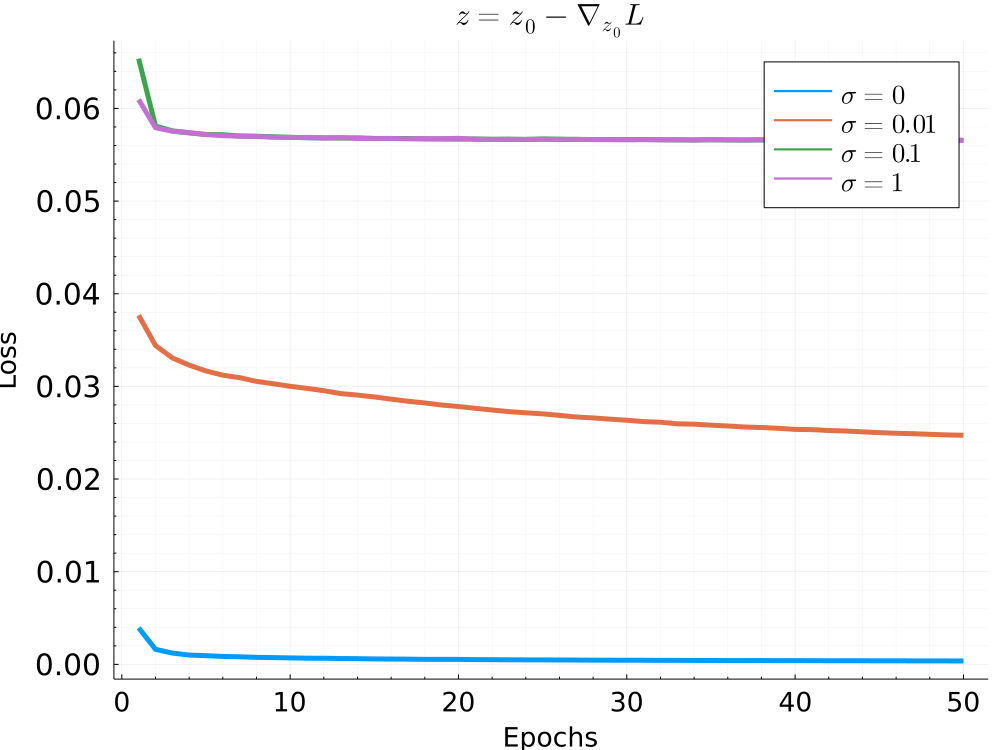

In [7]:
title = L"$z = z_0 - \nabla_{z_0}L$"
figsize = (1000,750)
epochs = 1:n_epochs

plot(epochs,trn_loss_list0[2:end] ,label = L"$\sigma = 0$", xlabel = "Epochs", ylabel = "Loss",
title = title, minorgrid = true, xtickfontsize = 18,
ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
yguidefontsize=18, titlefontsize = 20, size = figsize, thickness_scaling = 1, tickfontsize=20,linewidth=5)

plot!(epochs,trn_loss_list1[2:end]  ,label = L"$\sigma = 0.01$", xlabel = "Epochs", ylabel = "Loss",
title = title, minorgrid = true, xtickfontsize = 18,
ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
yguidefontsize=18, titlefontsize = 20, size = figsize, thickness_scaling = 1, tickfontsize=20,linewidth=5)

plot!(epochs,trn_loss_list2[2:end]  ,label = L"$\sigma = 0.1$", xlabel = "Epochs", ylabel = "Loss",
title = title, minorgrid = true, xtickfontsize = 18,
ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
yguidefontsize=18, titlefontsize = 20, size = figsize, thickness_scaling = 1, tickfontsize=20,linewidth=5)

plot!(epochs,trn_loss_list3[2:end]  ,label = L"$\sigma = 1$", xlabel = "Epochs", ylabel = "Loss",
title = title, minorgrid = true, xtickfontsize = 18,
ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
yguidefontsize=18, titlefontsize = 20, size = figsize, thickness_scaling = 1, tickfontsize=20,linewidth=5)

In [8]:
title = L"$z = z_0 - \nabla_{z_0}L$"
figsize = (1000,750)
epochs = 1:n_epochs

plot(epochs,trn_loss_list0[2:end] ,label = L"$\sigma = 0$", xlabel = "Epochs", ylabel = "Loss",
title = title, minorgrid = true, xtickfontsize = 18,
ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
yguidefontsize=18, titlefontsize = 20, size = figsize, thickness_scaling = 1, tickfontsize=20,linewidth=5)

plot!(epochs,trn_loss_list1[2:end]  ,label = L"$\sigma = 0.01$", xlabel = "Epochs", ylabel = "Loss",
title = title, minorgrid = true, xtickfontsize = 18,
ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
yguidefontsize=18, titlefontsize = 20, size = figsize, thickness_scaling = 1, tickfontsize=20,linewidth=5)

plot!(epochs,trn_loss_list2[2:end]  ,label = L"$\sigma = 0.1$", xlabel = "Epochs", ylabel = "Loss",
title = title, minorgrid = true, xtickfontsize = 18,
ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
yguidefontsize=18, titlefontsize = 20, size = figsize, thickness_scaling = 1, tickfontsize=20,linewidth=5)

plot!(epochs,trn_loss_list3[2:end]  ,label = L"$\sigma = 1$", xlabel = "Epochs", ylabel = "Loss",
title = title, minorgrid = true, xtickfontsize = 18,
ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
yguidefontsize=18, titlefontsize = 20, size = figsize, thickness_scaling = 1, tickfontsize=20,linewidth=5)

fig_name = "Ablation_Study_Latent_Initial"
savefig(joinpath("Ablation_Studies",fig_name))

In [7]:
CUDA.memory_status()    

Effective GPU memory usage: 99.88% (14.737 GiB/14.756 GiB)
Memory pool usage: 13.888 GiB (13.906 GiB reserved)